In [6]:
!pip install --upgrade pip
!pip install keras-tqdm

    100% |################################| 1.4MB 831kB/s eta 0:00:01   11% |###                             | 163kB 2.6MB/s eta 0:00:01    43% |##############                  | 614kB 1.9MB/s eta 0:00:01
  Found existing installation: pip 9.0.1
    Uninstalling pip-9.0.1:
      Successfully uninstalled pip-9.0.1


# Recurrent Neural Networks I

Classical neural networks, including convolutional ones, suffer from two severe limitations:

+ They only accept a fixed-sized vector as input and produce a fixed-sized vector as output.
+ They do not consider the sequential nature of some data (language, video frames, time series, etc.) 

Recurrent neural networks overcome these limitations by allowing to operate over sequences of vectors (in the input, in the output, or both).

## Vanilla Recurrent Neural Network

The basic formulas of a simple RNN are:

$$ \mathbf s_t = \mbox{tanh }(U \mathbf x_t + W \mathbf s_{t-1}) $$
$$ \mathbf y_t = V \mathbf s_t $$ 

where the hiperbollic tangent funtion ``tanh`` is: 

<img src="images/TanhReal.gif" alt="" style="width: 300px;"/>

These equations basically say that the current network state $s_t$, commonly known as hidden state,  is a function of the previous hidden state $\mathbf s_{t-1}$ and the current input $\mathbf x_t$. $U, V, W$ matrices are the parameters of the RNN and $\mathbf y_t$ is its output at time $t$. 

<img src="images/vanilla.png" alt="" style="width: 400px;"/>


## Unrolling in time of a RNN

Given an input sequence, we apply RNN formulas in a recurrent way until we process all input elements. **The RNN shares the parameters  $U,V,W$ across all recurrent steps**. 

Some important observations:
+ We can think of the hidden state  as a memory of the network that captures information about the previous steps. **It embeds the representation of the sequence.**
+ The output of the network can be considered at every stage or only at the final one (see bellow).
+ When starting to train a RNN we must provide initial values for $U,V,W$ as well as for $\mathbf s$.

By unrolling we mean that we write out the network for the complete sequence:


<img src="images/unrolling.png" alt="" style="width: 600px;"/>

Training a RNN involves the following steps:
+ Providing a training set composed of several input ($n$-dimensional) sequences $\{\mathbf{X}_i \}$ and their expected outcomes. Each element of a sequence $\mathbf{x}_j \in \mathbf{X}_i$ is also a vector.
+ Defining a loss function to measure the fitting of the output of the network to the expected outcome.
+ Applying SGD (or variants) to optimize the loss function.

## Vanilla Recurrent Neural Network (minibatch version)

Observe that the number of parameters of a RNN can be very high:

<img src="images/minibatch.png" alt="" style="width: 400px;"/>


It is not necessary to have outputs $y_t$ at each time step. Depending on the problem we are solving, we can have the following RNN architectures:

<img src="images/kar.png" alt="" style="width: 600px;"/>

Source: http://karpathy.github.io/2015/05/21/rnn-effectiveness/

RNN have shown success in:

+ Language modeling and generation.
+ Machine Translation.
+ Speech Recognition.
+ Image Description.
+ Question Answering.
+ Etc.

## RNN Computation

Defining a simple RNN with code is simple:

```python
class RNN:
    #...
    def step(self,x):
        self.h = np.tanh(np.dot(self.W_ss, self.h) + 
                 np.dot(self.W_xs, self.x))
        y = np.dot(self.W_sy, self.h)
        return y
    #...
```

We can go deep by stacking RNNs:
```python
y1 = rnn1.step(x)
y2 = rnn2.step(y1)
```

### RNN and information representation

The inputs of a recurrent network must be always **sequences of vectors**, but we can process sequences of symbols/words by representing these symbols by numerical vectors.

Let's suppose we are classifying a series of words $\mathbf x_1, ..., \mathbf x_{t-1}, \mathbf x_t, \mathbf x_{t+1}, ... \mathbf x_{n}$, where $\mathbf x_i$ are word vectors corresponding to a document with $n$ words that belong to a corpus with $|V|$ symbols. 

Then, the relationship to compute the hidden layer features at each time-step $t$ is $\mathbf s_t = \sigma(W^{(ss)} \mathbf s_{t-1} + W^{(sx)} \mathbf x_{t})$, where:

   + $\mathbf x_{t} \in \mathbb{R}^{d}$ is input word vector at time $t$. 
   + $W^{(sx)} \in \mathbb{R}^{D_s \times d}$ is the weights matrix used to condition the input word vector, $x_t$.
   + $W^{(ss)} \in \mathbb{R}^{D_s \times D_s}$ is the weights matrix used to condition the state of the previous time-step state, $s_{t-1}$.
   + $\mathbf s_{t-1}  \in \mathbb{R}^{D_s}$ is the state at the previous time-step, $s-1$. 
   + $\mathbf s_0 \in \mathbb{R}^{D_s}$ is an initialization vector for the hidden layer at time-step $t = 0$.
   + $\sigma ()$ is the non-linearity function (normally, ``tanh``).
   
In this case, the output of the network can be defined to be $\hat{\mathbf y}_t = softmax (W^{(sy)}\mathbf s_t)$ and the loss function cross-entropy, because we are dealing with a multiclass classification problem. 

$\hat{\mathbf y}$ is the output probability distribution over the vocabulary at each time-step $t$ (i.e. it is a high dimensional vector!).  

Essentially, $\hat{\mathbf y}_t$ is the next predicted word given the document context score so far (i.e. $\mathbf s_{t-1}$) and the last observed word vector $\mathbf x^{(t)}$. Here, $W^{(sy)} \in \mathbb{R}^{|V|\times D_h}$ and $\hat{\mathbf y} \in \mathbb{R}^{|V|}$ where $|V|$ is the cardinality of the vocabulary.

The loss function used in RNNs is often the cross entropy error:

$$
	L^{(t)} = - \sum_{j=1}^{|V|} y_{t,j} \times log (\hat{y}_{t,j})
$$

The cross entropy error over a document of size $n$ is:

$$
	L = \dfrac{1}{n} \sum_{t=1}^n L^{(t)}(W) = - \dfrac{1}{n} \sum_{t=1}^{n} \sum_{j=1}^{|V|} y_{t,j} \times log (\hat{y}_{t,j})
$$


In the case of classifying a series of symbols/words, the *perplexity* measure can be used to assess the goodness of our model. It is basically 2 to the power of the negative log probability of the cross entropy error function:

$$
	Perplexity = 2^{L}
$$

Perplexity is a measure of confusion where lower values imply more confidence in predicting the next word in the sequence (compared to the ground truth outcome).

## RNN Training

> Training a RNN is similar to training a traditional NN, but some modifications. The main reason is that parameters are shared by all time steps: in order to compute the gradient at $t=4$, we need to propagate 3 steps and sum up the gradients. This is called **Backpropagation through time (BPTT)**.

Recurrent neural networks propagate weight matrices from one time-step to the next. Recall the goal of a RNN implementation is to enable propagating context information through faraway time-steps. When these propagation results in a long series of matrix multiplications, weights can **vanish or explode**. 

+ Once the gradient value grows extremely large, it causes an overflow (i.e. ``NaN``) which is easily detectable at runtime; this issue is called the *Gradient Explosion Problem*. 

+ When the gradient value goes to zero, however, it can go undetected while drastically reducing the learning quality of the model for far-away words in the corpus; this issue is called the *Vanishing Gradient Problem*.

There are several tricks to mitigate these problems:

### Gradient Clipping

To solve the problem of exploding gradients, Thomas Mikolov first introduced a simple heuristic solution that *clips* gradients to a small number whenever they explode. That is, whenever they reach a certain threshold, they are set back to a small number. 

<img src="images/exploding.png" alt="" style="width: 400px;"/>


### Better initialization

To solve the problem of vanishing gradients, instead of initializing $W^{ss}$ randomly, starting off from **random orthogonal matrices** works better,  i.e., a square matrix $W$ for which $W^T W=I$.

There are two properties of orthogonal matrices that are useful for training deep neural networks:
+ they are norm-preserving, i.e., $ ||W \mathbf x||^2=||\mathbf x||^2$, and
+ their columns (and rows) are all orthonormal to one another.

At least at the start of training, the first of these should help to keep the norm of the input constant throughout the network, which can help with the problem of exploding/vanishing gradients. 

Similarly, an intuitive understanding of the second is that having orthonormal weight vectors encourages the weights to learn different input features.

You can obtain a random $n \times n$ orthogonal matrix $W$, (uniformly distributed) by performing a QR factorization of an $n \times n$ matrix with elements i.i.d. Gaussian random variables of mean $0$ and variance $1$. Here is an example:

In [1]:
import numpy as np
from scipy.linalg import qr

n = 3
H = np.random.randn(n, n)
print(H)
print('\n')

Q, R = qr(H)

print (Q.dot(Q.T))

[[ 0.21458923 -0.75934457 -0.06092018]
 [ 0.34512283  0.28496198 -1.72905968]
 [ 0.75684651  0.47333409 -1.15265316]]


[[1.00000000e+00 1.54149639e-16 8.00123841e-17]
 [1.54149639e-16 1.00000000e+00 4.28450955e-17]
 [8.00123841e-17 4.28450955e-17 1.00000000e+00]]


### Steeper Gates

We can make the "gates steeper" so they change more repidly from 0 to 1 and the model is learnt quicker.

<img src="images/steeper.png" alt="" style="width: 600px;"/>


## Gated RNN

Recurrent Neural Networks work just fine when we are dealing with short-term dependencies. 
However, vanilla RNNs fail to understand the lomg-term context dependencies (when relevant information may be separated from the point where it is needed by a huge load of irrelevant data).

Gated RNNs (with units that are designed to forget and to update relevant information) are a solution to this problem.

The most important types of gated RNNs are:

+ **Long Short Term Memories** (LSTM). It was introduced by S.Hochreiter and J.Schmidhuber in 1997 and is widely used. LSTM is very good in the long run due to its high complexity.
+ **Gated Recurrent Units** (GRU). It was recently introduced by K.Cho. It is simpler than LSTM, faster and optimizes quicker. 


#### LSTM

The key idea of LSTMs is to have two state representations: the hidden state $\mathbf h$ and the cell state $\mathbf C$ (instead of $\mathbf s$). 

The cell state $\mathbf C$ is like a conveyor belt. It runs straight down the entire chain, with only some minor linear interactions. It’s very easy for information to just flow along it unchanged.

<img src="images/lstm.png" alt="Source: http://colah.github.io/posts/2015-08-Understanding-LSTMs/" style="width: 600px;"/> 

LSTM has the ability to remove or add information to the cell state, carefully regulated by structures called **gates**.

Gates are a way to optionally let information through. They are composed out of a *sigmoid* neural net layer and a pointwise multiplication operation.

Let us see how a LSTM uses $\mathbf h_{t-1}, \mathbf C_{t-1}$ and $\mathbf x_{t}$ to generate the next states $\mathbf C_t, \mathbf h_{t}$:

$$ \mathbf f_t = \sigma(W^f \cdot [\mathbf h_{t-1}, \mathbf x_t]) \mbox{ (Forget gate)} $$
$$ \mathbf i_t = \sigma(W^i \cdot [\mathbf h_{t-1}, \mathbf x_t]) \mbox{ (Input gate)} $$
$$ \tilde {\mathbf C_t} = \operatorname{tanh}(W^C \cdot [\mathbf h_{t-1}, \mathbf x_t]) $$
$$ \mathbf C_t = \mathbf f_t \cdot \mathbf C_{t-1} + \mathbf i_t \cdot \tilde {\mathbf C_t} \mbox{ (Update gate)} $$
$$ \mathbf o_t = \sigma(W^o \cdot [\mathbf h_{t-1}, \mathbf x_t]) $$
$$ \mathbf h_t = \mathbf o_t \cdot \operatorname{tanh}(\mathbf C_t) \mbox{ (Output gate)} $$

where $[\mathbf h_{t-1}, \mathbf x_t]$ represents the concatenation of two vectors.

There are other variants of LSTM (f.e. LSTM with peephole connections of Gers & Schmidhuber (2000))

#### GRU

The transition from hidden state $\mathbf h_{t-1}$ to $\mathbf h_{t}$ in vanilla RNN is defined by using an affine transformation and a point-wise nonlinearity. 

What motivates the use of gated units? Although RNNs can theoretically capture long-term dependencies, they are very hard to actually train to do this. Gated recurrent units are designed in a manner to have more persistent memory thereby making it easier for RNNs to capture long-term dependencies. 

<img src="images/gru.png" alt="Source: http://colah.github.io/posts/2015-08-Understanding-LSTMs/" style="width: 300px;"/> 

Let us see how a GRU uses $\mathbf h_{t-1}$ and $\mathbf x_{t}$ to generate the next hidden state $\mathbf h_{t}$.

$$ \mathbf z_{t} = \sigma(W_z \cdot [\mathbf x_{t}, \mathbf h_{t-1}]) \mbox{ (Update gate)}$$
$$ \mathbf r_{t} = \sigma(W_r \cdot [\mathbf x_{t}, \mathbf h_{t-1}]) \mbox{ (Reset gate)}$$
$$ \tilde{\mathbf h}_{t} = \operatorname{tanh}(\mathbf r_{t} \cdot  [\mathbf x_{t}, \mathbf r_t \cdot \mathbf h_{t-1}]   ) \mbox{ (New memory)}$$
$$ \mathbf h_{t} = (1 - \mathbf z_{t}) \cdot \mathbf h_{t-1} + \mathbf z_{t} \cdot \tilde{\mathbf h}_{t} \mbox{(Hidden state)}$$

It combines the forget and input gates into a single “update gate.” It also merges the cell state and hidden state, and makes some other changes. The resulting model is simpler than standard LSTM models.

### RNN in Keras

Whenever you train or test your LSTM/GRU, you first have to build your input matrix $\mathbf X$ of shape ``[nb_samples,timesteps,input_dim]`` where your batch size divides ``nb_samples``. 

For instance, if ``nb_samples=1024`` and ``batch_size=64``, it means that your model will receive blocks of 64 samples, compute each output (whatever the number of timesteps is for every sample), average the gradients and propagate it to update the parameters vector. 

> By default, **Keras shuffles (permutes) the samples in $\mathbf X$** and consequently the dependencies between $\mathbf X_i$ and $\mathbf X_{i+1}$ are not considered. If
$\mathbf X_i$ and $\mathbf X_{i+1}$ represent independent sequences (f.e. different instances of a times series), this is not a problem. but if it represents parts of a bigger sequence (f.e. words in a text) it is!

> By using the **stateful model** all the states are propagated to the next batch. We must also prevent shuffling in the ``fit`` method.

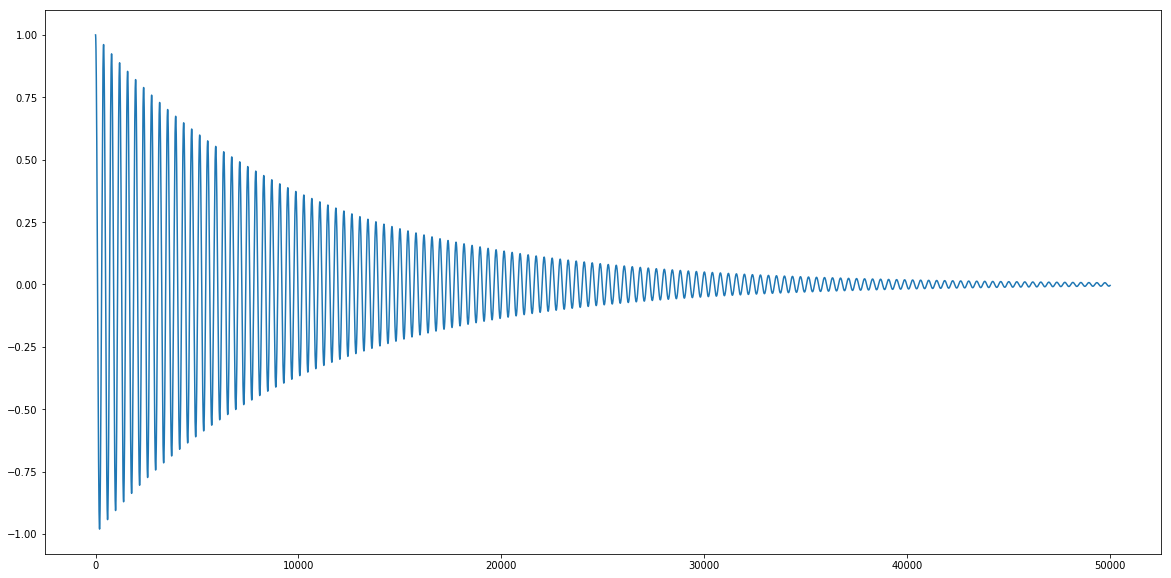

In [247]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers.core import Dense
from keras.layers.recurrent import LSTM, GRU
from keras_tqdm import TQDMNotebookCallback

%matplotlib inline

tsteps = 1
batch_size = 10

# number of elements ahead that are used to make the prediction
lahead = 1


def gen_cosine_amp(amp=100, period=10, x0=0, xn=50000, step=1, k=0.0001):
    """
    Generates an absolute cosine time series with the amplitude
    exponentially decreasing
    Arguments:
        amp: amplitude of the cosine function
        period: period of the cosine function
        x0: initial x of the time series
        xn: final x of the time series
        step: step of the time series discretization
        k: exponential rate
    """
    cos = np.zeros((xn - x0) * step)
    for i in range(len(cos)):
        idx = x0 + i * step
        cos[i] = amp * np.cos(idx / (2 * np.pi * period))
        cos[i] = cos[i] * np.exp(-k * idx)
    cos = cos / np.max(cos)
    return cos

cos = gen_cosine_amp()
plt.figure(figsize=(20,10))
plt.plot(cos)

In [249]:
# print('Generating Input Data')

lenght_series = 400
cos = gen_cosine_amp()
cos_series = np.zeros((50000-lenght_series, lenght_series, 1))

for i in range(50000-lenght_series):
    cos_series[i,:,:] = cos[i:i+lenght_series, np.newaxis]
    


print('Input shape:', cos_series.shape)


Input shape: (49600, 400, 1)


Output shape (49600, 1)
Sample:  [0.95748091]


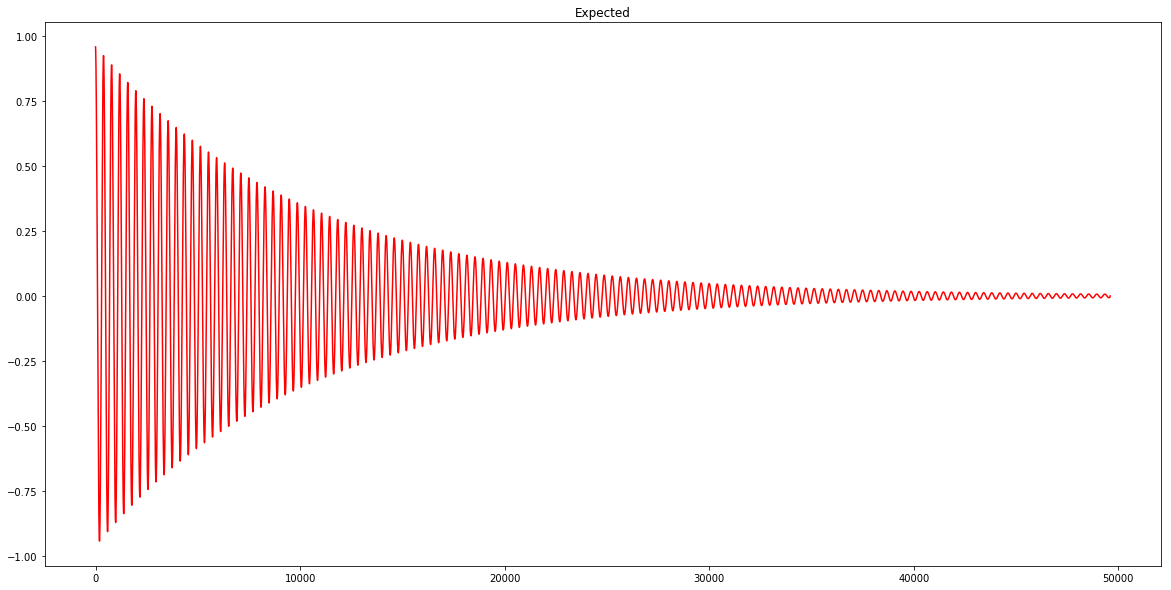

In [250]:
expected_output = np.zeros((len(cos)-lenght_series, 1))
for i in range(len(cos_series)-1):
    expected_output[i, 0] = cos[i+lenght_series]

print('Output shape', expected_output.shape)
print("Sample: ", expected_output[0])

plt.figure(figsize=(20,10))
plt.plot(expected_output,'-r')
plt.title('Expected')
plt.show()

In [251]:
epochs = 1

print('Creating Model')

model = Sequential()
model.add(LSTM(50,
               batch_input_shape=(None, lenght_series, 1),
               return_sequences=True,   # This param indicates whether to return 
                                        # the last output in the output
                                        # sequence, or the full sequence.
               stateful=False))
model.add(LSTM(50,
               batch_input_shape=(None, lenght_series, 1),
               return_sequences=False,
               stateful=False))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')

model.summary()

Creating Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_81 (LSTM)               (None, 400, 50)           10400     
_________________________________________________________________
lstm_82 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dense_41 (Dense)             (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


In [252]:
print('Training')

model.fit(cos_series,
          expected_output,
          batch_size=batch_size,
          verbose=0, 
          callbacks=[TQDMNotebookCallback()],
          epochs=epochs,
          shuffle=True)

Training


HBox(children=(IntProgress(value=0, description='Training', max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 0', max=49600), HTML(value='')))

Predicting...
Ploting Results


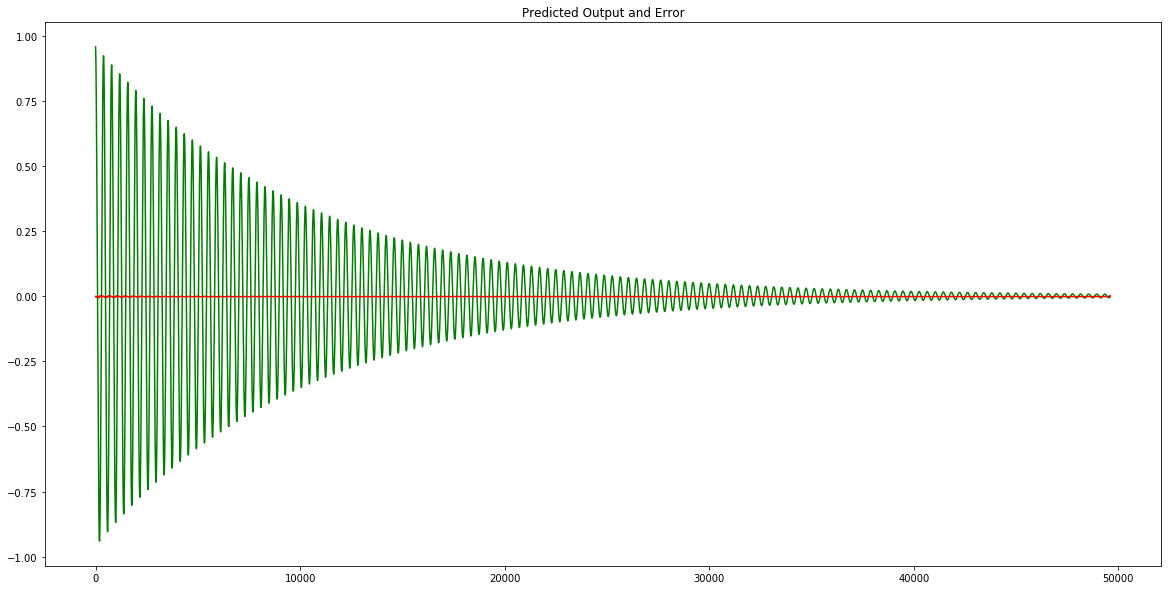

In [253]:
print('Predicting...')
predicted_output = model.predict(cos_series, batch_size=batch_size)

print('Ploting Results')
plt.figure(figsize=(20,10))
plt.plot(predicted_output,'-g')
plt.plot(expected_output - predicted_output,'-r')


plt.title('Predicted Output and Error')
plt.show()

In [204]:
future = np.zeros((1,10,1))
future[0,:,:] = cos[10000:10010, np.newaxis]
print(future)

predicted_future = model.predict(future)
print(predicted_future)

[[[0.24823921]
  [0.24648111]
  [0.24471338]
  [0.24293608]
  [0.24114929]
  [0.23935308]
  [0.23754753]
  [0.23573271]
  [0.2339087 ]
  [0.23207557]]]
[[0.23126628]]


0.9579935073852539


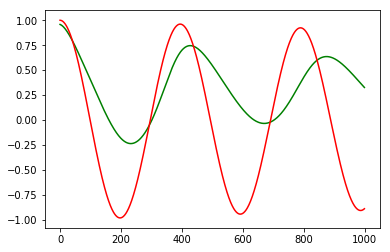

In [256]:
future = np.zeros((1,lenght_series,1))
future[0,:,:] = cos[:lenght_series, np.newaxis]
predicted_future = np.zeros((1000,))


for i in range(1000):
    predicted_future[i] = model.predict(future)
    future[0,0:lenght_series-1,0] = future[0,1:lenght_series,0]
    future[0,lenght_series-1,0] = predicted_future[i]

print(predicted_future[0])
plt.plot(predicted_future,'-g')
plt.plot(cos[:1000],'-r')